In [27]:
import warnings
warnings.filterwarnings('ignore')

In [28]:
from datetime import date
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [29]:
from bokeh.core.enums import SizingMode
from bokeh.layouts import layout, column, row
from bokeh.models import ColumnDataSource, HoverTool, Slider, CustomJS, TextInput, Div, RangeSlider, DateRangeSlider, Select
from bokeh.plotting import figure, output_file, save, show

## Helpers

In [30]:
# Index by year and quarter.
# Helper function for a couple
# of different datasets.
def monthToQuarter(qrt):
    month = ''
    if (qrt == 'Qtr1'):
        month = 'Jan'
    elif (qrt == 'Qtr2'):
        month = 'Apr'
    elif (qrt == 'Qtr3'):
        month = 'Aug'
    elif (qrt == 'Qtr4'):
        month = 'Oct'
    else:
        raise Exception('Cannot convert quarter to month')
    return month

## Datasource

In [31]:
# Use BLS-issued series ID.
CPI_SRC = 'data/CUUR0000AA0.xlsx'
UNEMP_SRC = 'data/LNS14000000.xlsx'
ECI_SRC = 'data/CIU2020000000000A.xlsx'
EMP_SRC = 'data/CES0000000001.xlsx'
PROD_SRC = 'data/PRS85006092.xlsx'

## Settings

In [32]:
MEDIUM_TERM = '2001-01-01'  # Dotcom bust. Many charts begin here; leave as-is.
SHORT_TERM = '2008-01-01'  # Great recession.
SHORTER_TERM = '2020-01-01'  # Pandemic.

## CPI Dataset

In [33]:
df_cpi_orig = pd.read_excel(CPI_SRC, skiprows=list(range(11)))
df_cpi_orig.drop(['HALF1', 'HALF2'], inplace=True, axis=1)

In [35]:
# Start at CPI=1967
df_cpi_orig = df_cpi_orig[df_cpi_orig['Year'] >= 1967]

# Index by date.
df_cpi_melted = df_cpi_orig.melt(id_vars='Year', var_name='Month', value_name='Value')
df_cpi_melted['Date'] = df_cpi_melted['Year'].astype(str) + '-' + df_cpi_melted['Month']
df_cpi_melted['Date'] = pd.to_datetime(df_cpi_melted['Date'], format='%Y-%b')
df_cpi = df_cpi_melted.set_index('Date')
df_cpi = df_cpi.sort_index()

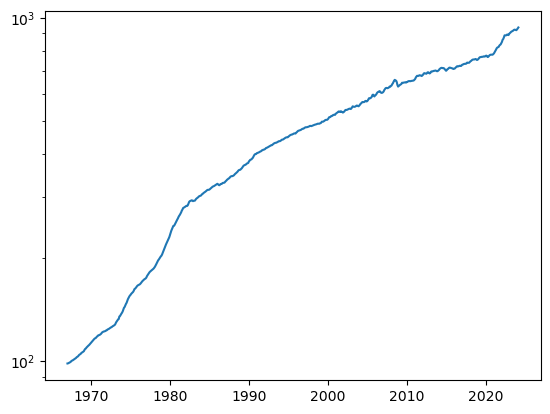

In [37]:
plt.yscale('log')
plt.plot(df_cpi.index, df_cpi['Value'])

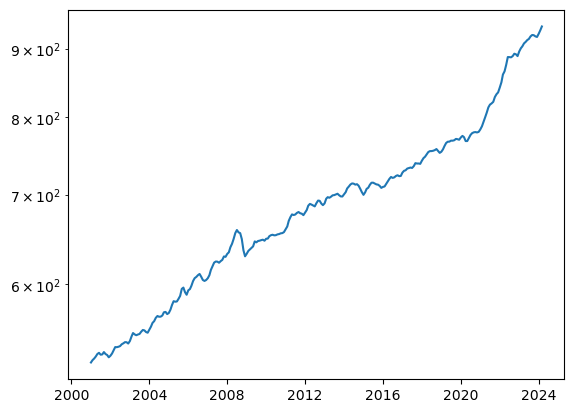

In [38]:
plt.yscale('log')
plt.plot(df_cpi[df_cpi.index >= MEDIUM_TERM].index, df_cpi[df_cpi.index >= MEDIUM_TERM]['Value']) # Other charts start at 2001.

### Bokeh (CPI)

In [39]:
cpi_div = Div(
    text="""
        <p>This is some text.</p>
        """,
    width=200,
    height=30,
)

In [40]:
# Plot setup.
cpi_plot = figure(
    height=400,
    width=800,
    title="CPI",
    x_axis_label='Date',
    y_axis_label='1967 dollars (%)',
    x_axis_type="datetime",
    y_axis_type="log",
    tools="",
)

In [41]:
# Date range widget.
cpi_date_range_slider = DateRangeSlider(
    title="Adjust x-axis range",
    value=(date(1967, 1, 1), date(2024, 1, 1)), # Hard code for now.
    start=date(1967, 1, 1),
    end=date(2024, 1, 1),
    step=365,
)

# Bind slider to plot for auto updating.
cpi_date_range_slider.js_link('value', cpi_plot.x_range, 'start', attr_selector=0)
cpi_date_range_slider.js_link('value', cpi_plot.x_range, 'end', attr_selector=1)

In [53]:
# Data source.
cpi_source = ColumnDataSource(data={'x': df_cpi.index, 'y': df_cpi['Value'], 'smoothed_y': df_cpi['Value']})

# Line plot.
cpi_line = cpi_plot.line('x', 'y', source=cpi_source, line_width=1, line_alpha=0.6, legend_label='Actual')

# Smoothed line plot.
cpi_smoothed_line = cpi_plot.line('x', 'smoothed_y', source=cpi_source, line_width=2, color='red', legend_label='Smooth')

# Resize viewport widget.
cpi_view_size_select = Select(title="Sizing mode", value="fixed", options=list(SizingMode), width=300)
cpi_view_size_select.js_link('value', cpi_plot, 'sizing_mode')

# Resize window widget.
cpi_window_callback = CustomJS(args=dict(source=cpi_source, smoothed_line=cpi_smoothed_line), code="""
    var data = source.data;
    var y = data['y'];
    var smoothed_y = data['smoothed_y'];
    var window_size = cb_obj.value;
    var N = y.length;
    
    // Simple moving average for smoothing
    for (var i = 0; i < N; i++) {
        var sum = 0.0;
        var count = 0;
        for (var j = Math.max(0, i - Math.floor(window_size / 2)); j < Math.min(N, i + Math.ceil(window_size / 2)); j++) {
            sum += y[j];
            count += 1;
        }
        smoothed_y[i] = sum / count;
    }
    
    // Update the plot
    smoothed_line.glyph.change.emit();
""")
cpi_window_size_slider = Slider(start=3, end=100, value=5, step=2, title="Window Size")
cpi_window_size_slider.js_on_change('value', cpi_window_callback)

# Line thickness widget.
cpi_thickness_slider_line = Slider(title="slide input", value=1.0, start=0.1, end=5.0, step=0.1)
cpi_thickness_slider_line_callback = CustomJS(args=dict(line=cpi_line, slider=cpi_thickness_slider_line), code="""
    line.glyph.line_width = slider.value;
""")
cpi_thickness_slider_line.js_on_change('value', cpi_thickness_slider_line_callback)

# Smoothed line thickness widget.
cpi_thickness_slider_smoothed = Slider(title="slide input", value=1.0, start=0.1, end=5.0, step=0.1)
cpi_thickness_slider_smoothed_callback = CustomJS(args=dict(line=cpi_smoothed_line, slider=cpi_thickness_slider_smoothed), code="""
    line.glyph.line_width = slider.value;
""")
cpi_thickness_slider_smoothed.js_on_change('value', cpi_thickness_slider_smoothed_callback)

# Build layout.
cpi_layout = column(
    cpi_window_size_slider,
    cpi_date_range_slider,
    cpi_view_size_select,
    cpi_thickness_slider_line,
    cpi_thickness_slider_smoothed,
    cpi_plot
)
# cpi_layout.sizing_mode = "stretch_both"

# Save layout.
# output_file("cpi.html")
# save(cpi_layout)

<hr>

## Unemployment Dataset

In [43]:
df_unemp_orig = pd.read_excel(UNEMP_SRC, skiprows=list(range(11)))

In [45]:
# Start at CPI=1967
df_unemp_orig = df_unemp_orig[df_unemp_orig['Year'] >= 1967]

# Index by date.
df_unemp_melted = df_unemp_orig.melt(id_vars='Year', var_name='Month', value_name='Value')
df_unemp_melted['Date'] = df_unemp_melted['Year'].astype(str) + '-' + df_unemp_melted['Month']
df_unemp_melted['Date'] = pd.to_datetime(df_unemp_melted['Date'], format='%Y-%b')
df_unemp = df_unemp_melted.set_index('Date')
df_unemp = df_unemp.sort_index()

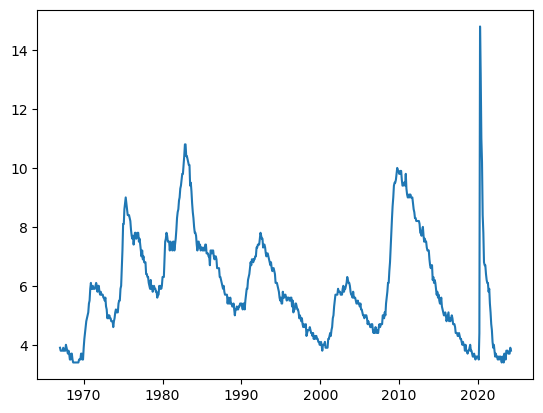

In [46]:
plt.yscale('linear')
plt.plot(df_unemp.index, df_unemp['Value'])

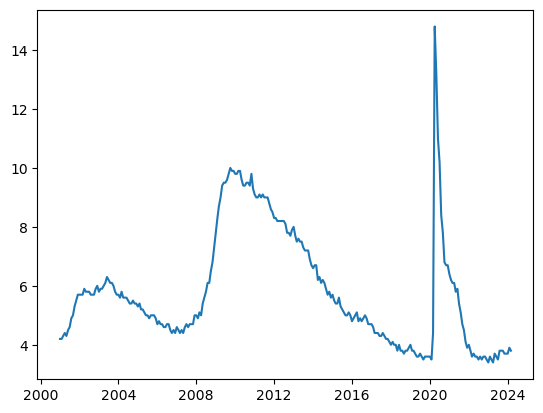

In [48]:
plt.yscale('linear')
plt.plot(df_unemp[df_unemp.index >= MEDIUM_TERM].index, df_unemp[df_unemp.index >= MEDIUM_TERM]['Value']) # Other charts start at 2001.

### Unemployment (Bokeh)

In [49]:
# Plot setup.
unemp_plot = figure(
    height=400,
    width=800,
    title="CPI",
    x_axis_label='Date',
    y_axis_label='1967 dollars (%)',
    x_axis_type="datetime",
    y_axis_type="log",
    tools="",
)

In [50]:
# Date range widget.
unemp_date_range_slider = DateRangeSlider(
    title="Adjust x-axis range",
    value=(date(1967, 1, 1), date(2024, 1, 1)), # Hard code for now.
    start=date(1967, 1, 1),
    end=date(2024, 1, 1),
    step=365,
)

# Bind slider to plot for auto updating.
unemp_date_range_slider.js_link('value', unemp_plot.x_range, 'start', attr_selector=0)
unemp_date_range_slider.js_link('value', unemp_plot.x_range, 'end', attr_selector=1)

In [51]:
# Data source.
unemp_source = ColumnDataSource(data={'x': df_unemp.index, 'y': df_unemp['Value'], 'smoothed_y': df_unemp['Value']})

# Line plot.
unemp_line = unemp_plot.line('x', 'y', source=unemp_source, line_width=1, line_alpha=0.6, legend_label='Actual')

# Smoothed line plot.
unemp_smoothed_line = unemp_plot.line('x', 'smoothed_y', source=unemp_source, line_width=2, color='red', legend_label='Smooth')

# Resize viewport widget.
unemp_view_size_select = Select(title="Sizing mode", value="fixed", options=list(SizingMode), width=300)
unemp_view_size_select.js_link('value', unemp_plot, 'sizing_mode')

# Resize window widget.
unemp_window_callback = CustomJS(args=dict(source=unemp_source, smoothed_line=unemp_smoothed_line), code="""
    var data = source.data;
    var y = data['y'];
    var smoothed_y = data['smoothed_y'];
    var window_size = cb_obj.value;
    var N = y.length;
    
    // Simple moving average for smoothing
    for (var i = 0; i < N; i++) {
        var sum = 0.0;
        var count = 0;
        for (var j = Math.max(0, i - Math.floor(window_size / 2)); j < Math.min(N, i + Math.ceil(window_size / 2)); j++) {
            sum += y[j];
            count += 1;
        }
        smoothed_y[i] = sum / count;
    }
    
    // Update the plot
    smoothed_line.glyph.change.emit();
""")
unemp_window_size_slider = Slider(start=3, end=100, value=5, step=2, title="Window Size")
unemp_window_size_slider.js_on_change('value', unemp_window_callback)

# Build layout.
unemp_layout = column(
    unemp_window_size_slider,
    unemp_date_range_slider,
    unemp_view_size_select,
    unemp_plot
)
# unemp_layout.sizing_mode = "stretch_both"

# Save layout.
# output_file("unemployment.html")
# save(unemp_layout)

## Gridplot

In [52]:
from bokeh.layouts import gridplot

# Vertical layout.
column_layout = column(
    cpi_window_size_slider,
    cpi_date_range_slider,
    cpi_view_size_select,
    unemp_window_size_slider,
    unemp_date_range_slider,
    unemp_view_size_select,
    cpi_plot,
    unemp_plot,
)

# Stretch both.
grid = gridplot([[column_layout]], sizing_mode='stretch_both')

# Save layout.
output_file("grid.html")
save(grid)

'/Users/nketchum/Library/CloudStorage/Dropbox/Academics/SI 649/Narrative Viz/grid.html'

### CPI + Unemployment

In [ ]:
# Plot setup.
super_plot = figure(
    height=800,
    width=600,
    title="Superplot",
    x_axis_label='X axis',
    y_axis_label='Y axis',
    x_axis_type="datetime",
    tools="",
)

# Date range widget.
super_date_range_slider = DateRangeSlider(
    title="Adjust x-axis range",
    value=(date(1967, 1, 1), date(2024, 1, 1)), # Hard code for now.
    start=date(1967, 1, 1),
    end=date(2024, 1, 1),
    step=365,
)
# Bind slider to plot for auto updating.
super_date_range_slider.js_link('value', super_plot.x_range, 'start', attr_selector=0)
super_date_range_slider.js_link('value', super_plot.x_range, 'end', attr_selector=1)

# CPI data source.
cpi_source = ColumnDataSource(data={'x': df_cpi.index, 'y': df_cpi['Value'], 'smoothed_y': df_cpi['Value']})
cpi_line = super_plot.line('x', 'y', source=cpi_source, line_width=1, line_alpha=0.6, legend_label='Actual')
cpi_smoothed_line = super_plot.line('x', 'smoothed_y', source=cpi_source, line_width=2, color='red', legend_label='Smooth')

# Unemp data source.
unemp_source = ColumnDataSource(data={'x': df_unemp.index, 'y': df_unemp['Value'], 'smoothed_y': df_unemp['Value']})
unemp_line = super_plot.line('x', 'y', source=unemp_source, line_width=1, line_alpha=0.6, legend_label='Actual')
unemp_smoothed_line = super_plot.line('x', 'smoothed_y', source=unemp_source, line_width=2, color='red', legend_label='Smooth')

# Resize viewport widget.
super_view_size_select = Select(title="Sizing mode", value="fixed", options=list(SizingMode), width=300)
super_view_size_select.js_link('value', super_plot, 'sizing_mode')

# CPI resize window widget.
super_cpi_window_callback = CustomJS(args=dict(source=cpi_source, smoothed_line=cpi_smoothed_line), code="""
    var data = source.data;
    var y = data['y'];
    var smoothed_y = data['smoothed_y'];
    var window_size = cb_obj.value;
    var N = y.length;
    
    // Simple moving average for smoothing
    for (var i = 0; i < N; i++) {
        var sum = 0.0;
        var count = 0;
        for (var j = Math.max(0, i - Math.floor(window_size / 2)); j < Math.min(N, i + Math.ceil(window_size / 2)); j++) {
            sum += y[j];
            count += 1;
        }
        smoothed_y[i] = sum / count;
    }
    
    // Update the plot
    smoothed_line.glyph.change.emit();
""")
super_cpi_window_size_slider = Slider(start=3, end=100, value=5, step=2, title="Window Size")
super_cpi_window_size_slider.js_on_change('value', super_cpi_window_callback)

# Unemp resize window widget.
super_unemp_window_callback = CustomJS(args=dict(source=unemp_source, smoothed_line=unemp_smoothed_line), code="""
    var data = source.data;
    var y = data['y'];
    var smoothed_y = data['smoothed_y'];
    var window_size = cb_obj.value;
    var N = y.length;
    
    // Simple moving average for smoothing
    for (var i = 0; i < N; i++) {
        var sum = 0.0;
        var count = 0;
        for (var j = Math.max(0, i - Math.floor(window_size / 2)); j < Math.min(N, i + Math.ceil(window_size / 2)); j++) {
            sum += y[j];
            count += 1;
        }
        smoothed_y[i] = sum / count;
    }
    
    // Update the plot
    smoothed_line.glyph.change.emit();
""")
super_unemp_window_size_slider = Slider(start=3, end=100, value=5, step=2, title="Window Size")
super_unemp_window_size_slider.js_on_change('value', super_unemp_window_callback)

# Build layout.
super_layout = column(
    super_cpi_window_size_slider,
    super_unemp_window_size_slider,
    super_date_range_slider,
    super_view_size_select,
    super_plot
)

super_layout.sizing_mode = "stretch_both"

output_file("super.html")
save(super_layout)

## Employment Cost Index

In [ ]:
df_eci_orig = pd.read_excel(ECI_SRC, skiprows=list(range(15)))

In [ ]:
# Insert month from biz quarter.
df_eci_orig['Month'] = df_eci_orig['Period'].apply(monthToQuarter)

# Make date index
df_eci_orig['Date'] = df_eci_orig.apply(lambda row: f"{row['Year']}-{row['Month']}", axis=1)
df_eci_orig['Date'] = pd.to_datetime(df_eci_orig['Date'], format='%Y-%b')
df_eci = df_eci_orig.set_index('Date')
df_eci = df_eci.sort_index()
df_eci.drop(['Standard Error', 'Month', 'Period', 'Year'], axis=1, inplace=True)

In [ ]:
plt.yscale('linear')
plt.plot(df_eci.index, df_eci['Estimate Value'])

## Employment Hours

In [ ]:
df_emp_orig = pd.read_excel(EMP_SRC, skiprows=list(range(12)))

In [ ]:
# Start at CPI=1967
df_emp_orig = df_emp_orig[df_emp_orig['Year'] >= 1967]

# Index by date.
df_emp_melted = df_emp_orig.melt(id_vars='Year', var_name='Month', value_name='Value')
df_emp_melted['Date'] = df_emp_melted['Year'].astype(str) + '-' + df_emp_melted['Month']
df_emp_melted['Date'] = pd.to_datetime(df_emp_melted['Date'], format='%Y-%b')
df_emp = df_emp_melted.set_index('Date')
df_emp = df_emp.sort_index()
df_emp.drop(['Year', 'Month'], axis=1, inplace=True)

In [ ]:
plt.yscale('linear')
plt.plot(df_emp.index, df_emp['Value'])

In [ ]:
plt.yscale('linear')
plt.plot(df_emp[df_emp.index >= MEDIUM_TERM].index, df_emp[df_emp.index >= MEDIUM_TERM]['Value'])

## Productivity

In [ ]:
df_prod_orig = pd.read_excel(PROD_SRC, skiprows=list(range(10)))

In [ ]:
# Start at CPI=1967
df_prod_orig = df_prod_orig[df_prod_orig['Year'] >= 1967]

# Index by date.
df_prod_melted = df_prod_orig.melt(id_vars='Year', var_name='Quarter', value_name='Value')
df_prod_melted['Month'] = df_prod_melted['Quarter'].apply(monthToQuarter)
df_prod_melted['Date'] = df_prod_melted['Year'].astype(str) + '-' + df_prod_melted['Month']
df_prod_melted['Date'] = pd.to_datetime(df_prod_melted['Date'], format='%Y-%b')
df_prod = df_prod_melted.set_index('Date')
df_prod = df_prod.sort_index()
df_prod.drop(['Year', 'Quarter', 'Month'], axis=1, inplace=True)

In [ ]:
plt.yscale('linear')
plt.plot(df_prod.index, df_prod['Value'])

In [ ]:
plt.yscale('linear')
plt.plot(df_prod[df_prod.index >= MEDIUM_TERM].index, df_prod[df_prod.index >= MEDIUM_TERM]['Value'])